# Adaption Evaluation
Comparision between: 
- MAML
- pretrained model

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import vectorbt as vbt

sns.set()
import plotly.graph_objects as go
from copy import deepcopy
from stock_env.envs import *
from stock_env.common.common_utils import (
    open_config,
    create_performance,
    plot_trade_log_v2,
)
from stock_env.exp_manager import ExperimentManager
from stock_env.algos.maml import adapt, get_task_loss
from stock_env.algos.buffer import RolloutBuffer
from stock_env.algos.agent import MetaAgent
from stock_env.common.evaluation import evaluate_agent, play_an_episode


def plot_mean_reward(fig, df, fill_color, line_color, name):

    fig.add_trace(
        go.Scatter(
            x=df["n_adapt_steps"],
            y=df["mean-std"],
            mode="lines",
            fill=None,
            line=dict(width=0.5, color=fill_color),
            showlegend=False,
        )
    )

    fig.add_trace(
        go.Scatter(
            x=df["n_adapt_steps"],
            y=df["mean+std"],
            fill="tonexty",
            mode="lines",
            line=dict(width=0.5, color=fill_color),
            showlegend=False,
        )
    )

    fig.add_trace(
        go.Scatter(
            x=df["n_adapt_steps"],
            y=df["mean"],
            fill=None,
            line_color=line_color,
            name=name,
        )
    )

In [2]:
ARGS_PATH = "../configs/maml.yaml"
ENV_ID = "VNALL-v0"
METHODS_STATE_DICT = {
    "random": None,
    "maml": "../model/maml_sp500_20221225_083711.pth",
}
exp = ExperimentManager(
    args_path=ARGS_PATH, env_id=ENV_ID, methods_state_dict=METHODS_STATE_DICT
)

In [ ]:
adaption_results = exp.mass_adaption_results(
    methods=["maml"],
    maybe_num_tasks=5,
    total_adapt_steps=4,
    n_eval_episodes=5,
)
adaption_results

In [ ]:
agg_stats = adaption_results.groupby("n_adapt_steps").agg({"mean": "mean"})
agg_stats.reset_index(inplace=True)

In [ ]:
import plotly.express as px

fig = px.line(
    agg_stats,
    x="n_adapt_steps",
    y="mean",
    # color="task",
    # color_discrete_sequence=px.colors.qualitative.Antique,
)
fig.show()

In [3]:
TASKS = ["HAH", "HPG", "VND", "VNM"]

trading_performance, params = exp.mass_trading_performance(
    methods=["maml"],
    maybe_num_tasks=TASKS,
    total_adapt_steps=3,
)
trading_performance

2022-12-25 12:21:13,206 : INFO : Adapt #0: trading 'HAH' with method 'maml'...


Ticker: HAH, from date 2016-11-02 00:00:00 to date 2017-11-01 00:00:00


2022-12-25 12:21:34,029 : INFO : Adapt #1: trading 'HAH' with method 'maml'...


Ticker: HAH, from date 2016-11-02 00:00:00 to date 2017-11-01 00:00:00


2022-12-25 12:21:54,666 : INFO : Adapt #2: trading 'HAH' with method 'maml'...


Ticker: HAH, from date 2017-11-01 00:00:00 to date 2018-11-02 00:00:00


2022-12-25 12:22:15,310 : INFO : Adapt #3: trading 'HAH' with method 'maml'...


Ticker: HAH, from date 2016-11-02 00:00:00 to date 2017-11-01 00:00:00


2022-12-25 12:22:35,956 : INFO : Adapt #0: trading 'HPG' with method 'maml'...


Ticker: HPG, from date 2018-11-02 00:00:00 to date 2019-11-05 00:00:00


2022-12-25 12:22:56,638 : INFO : Adapt #1: trading 'HPG' with method 'maml'...


Ticker: HPG, from date 2017-11-01 00:00:00 to date 2018-11-02 00:00:00


2022-12-25 12:23:17,216 : INFO : Adapt #2: trading 'HPG' with method 'maml'...


Ticker: HPG, from date 2017-11-01 00:00:00 to date 2018-11-02 00:00:00


2022-12-25 12:23:37,870 : INFO : Adapt #3: trading 'HPG' with method 'maml'...


Ticker: HPG, from date 2018-11-02 00:00:00 to date 2019-11-05 00:00:00


2022-12-25 12:23:58,488 : INFO : Adapt #0: trading 'VND' with method 'maml'...


Ticker: VND, from date 2016-11-02 00:00:00 to date 2017-11-07 00:00:00


2022-12-25 12:24:19,082 : INFO : Adapt #1: trading 'VND' with method 'maml'...


Ticker: VND, from date 2017-11-07 00:00:00 to date 2018-11-08 00:00:00


2022-12-25 12:24:39,784 : INFO : Adapt #2: trading 'VND' with method 'maml'...


Ticker: VND, from date 2017-11-07 00:00:00 to date 2018-11-08 00:00:00


2022-12-25 12:25:00,774 : INFO : Adapt #3: trading 'VND' with method 'maml'...


Ticker: VND, from date 2016-11-02 00:00:00 to date 2017-11-07 00:00:00


2022-12-25 12:25:21,701 : INFO : Adapt #0: trading 'VNM' with method 'maml'...


Ticker: VNM, from date 2018-11-02 00:00:00 to date 2019-11-05 00:00:00


2022-12-25 12:25:42,733 : INFO : Adapt #1: trading 'VNM' with method 'maml'...


Ticker: VNM, from date 2018-11-02 00:00:00 to date 2019-11-05 00:00:00


2022-12-25 12:26:03,857 : INFO : Adapt #2: trading 'VNM' with method 'maml'...


Ticker: VNM, from date 2018-11-02 00:00:00 to date 2019-11-05 00:00:00


2022-12-25 12:26:25,074 : INFO : Adapt #3: trading 'VNM' with method 'maml'...


Ticker: VNM, from date 2017-11-01 00:00:00 to date 2018-11-02 00:00:00


maml
n_adapt_steps ticker metric                    
0             HAH    annual_return     -0.02849
                     cum_returns_final -0.02826
                     sharpe_ratio      -0.32634
                     max_drawdown       -0.0894
                     annual_volatility  0.07932
...                                         ...
3             VNM    cum_returns_final -0.04347
                     sharpe_ratio      -0.51246
                     max_drawdown       -0.1334
                     annual_volatility  0.08135
                     value_at_risk          NaN

[96 rows x 1 columns]

In [4]:
trading_performance.loc[
    (slice(0, 5), TASKS, ("sharpe_ratio", "max_drawdown")), :
].sort_index()

maml
n_adapt_steps ticker metric               
0             HAH    max_drawdown  -0.0894
                     sharpe_ratio -0.32634
              HPG    max_drawdown -0.20367
                     sharpe_ratio  -1.1175
              VND    max_drawdown  -0.1021
                     sharpe_ratio  1.25148
              VNM    max_drawdown -0.11536
                     sharpe_ratio  0.80681
1             HAH    max_drawdown  -0.0992
                     sharpe_ratio -0.35978
              HPG    max_drawdown -0.16544
                     sharpe_ratio  1.32196
              VND    max_drawdown -0.21173
                     sharpe_ratio  0.62174
              VNM    max_drawdown -0.09952
                     sharpe_ratio  0.69281
2             HAH    max_drawdown -0.25767
                     sharpe_ratio  -1.5237
              HPG    max_drawdown -0.15552
                     sharpe_ratio  1.32126
              VND    max_drawdown -0.21407
                     sharpe_ratio   0.6271
              VNM    max_drawdown -0.10187
                     sharpe_ratio  0.71891
3             HAH    max_drawdown -0.10108
                     sharpe_ratio -0.36027
              HPG    max_drawdown -0.18695
                     sharpe_ratio -1.09584
              VND    max_drawdown -0.11202
                     sharpe_ratio  1.30757
              VNM    max_drawdown  -0.1334
                     sharpe_ratio -0.51246

# Evaluate task trading performance

Ticker: HAH, from date 2022-11-03 00:00:00 to date 2022-12-22 00:00:00

        Annual return     : -39.10%
        Cumulative return : -6.66%
        Sharpe ratio      : -1.29
        Maximum Drawdown  : -17.61%
        Annual Volatility :  34.88%
        Value-At-Risk     :  nan%
        


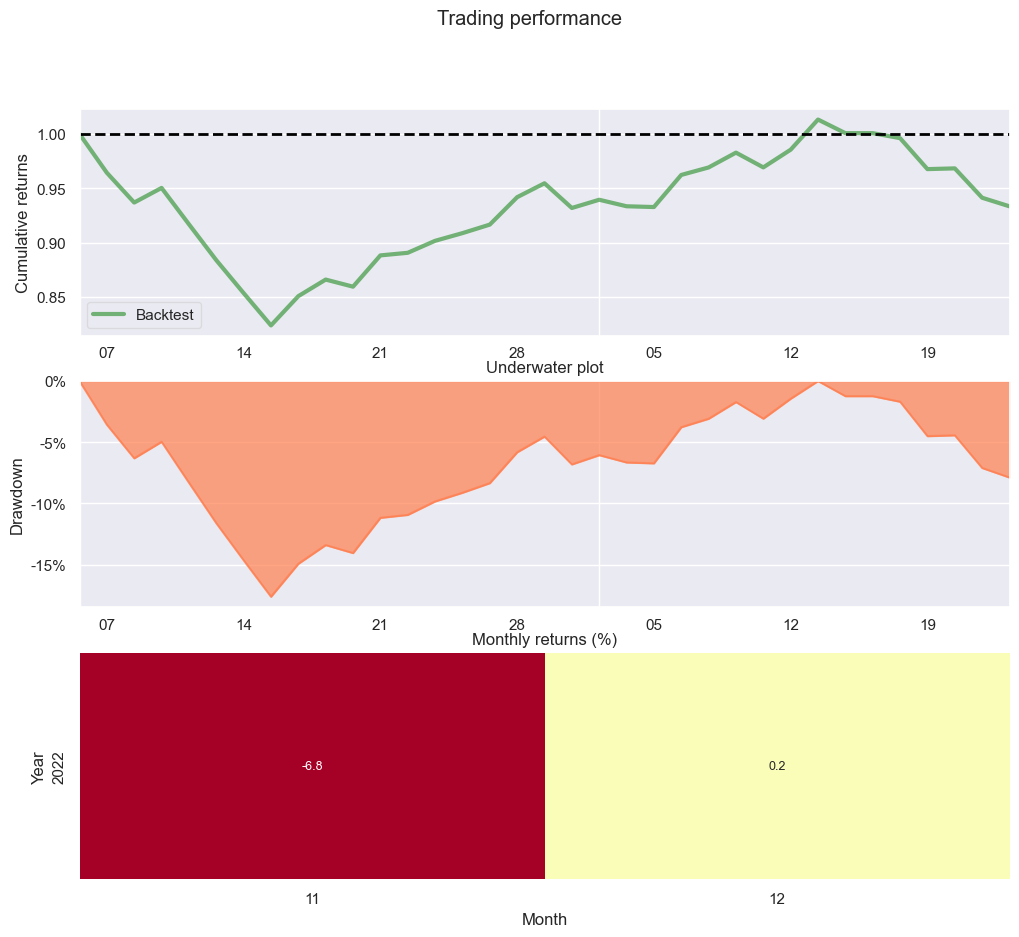

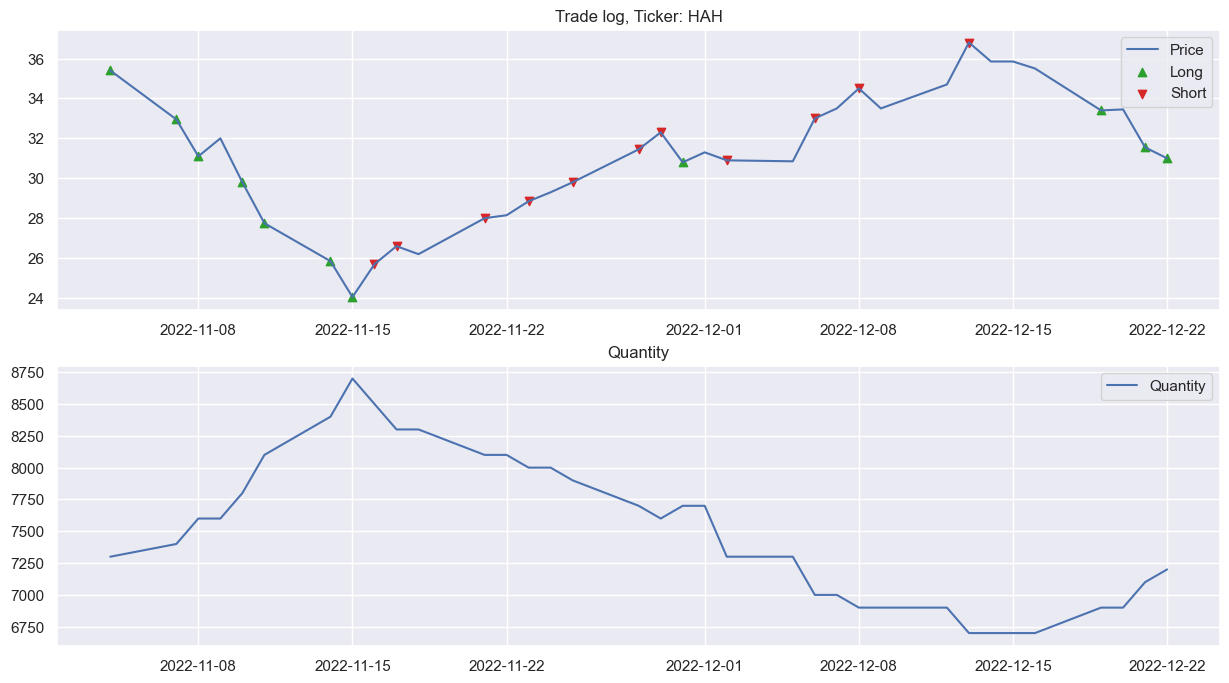

In [21]:
ENV_ID = "VNALL-v0"
TASK = "HAH"
ITH_ADAPT_STEP = 0

args = open_config("../configs/maml.yaml", env_id=ENV_ID)
envs = MetaVectorEnv([lambda: gym.make(ENV_ID) for _ in range(1)])
agent = MetaAgent(envs=envs, hiddens=args.hiddens)
agent.load_state_dict(params["maml"][TASK][ITH_ADAPT_STEP])

envs.train(False)
envs.reset_task(TASK)

info = play_an_episode(agent, envs)
df = info["final_info"][0]["final_history"]

returns = df.set_index("time")["portfolio_value"].pct_change()
perf = create_performance(returns, plot=True)

plot_trade_log_v2(df)

# portfolio value from hodling
df["pv_from_holding"] = vbt.Portfolio.from_holding(
    df.close, init_cash=envs.envs[0].init_cash
).value()
df = df.set_index("time")
ticker = df["ticker_x"].unique()[0]

fig = go.Figure()
fig.update_layout(width=800, height=500)
fig.update_layout(title=f"Buy-n-Hold Comparision, Ticker: {ticker}", title_x=0.5)
fig.update_xaxes(title_text="Date")
fig.update_yaxes(title_text="Portfolio Value (VND)")

df["portfolio_value"].vbt.plot_against(
    other=df["pv_from_holding"],
    other_trace_kwargs=dict(
        line=dict(width=2, color="dimgray"), mode="lines", name="Buy-n-Hold"
    ),
    trace_kwargs=dict(
        mode="lines+markers",
        line=dict(width=3, color="lightslategray"),
        name="MAML",
    ),
    pos_trace_kwargs=dict(fillcolor="palegreen"),
    neg_trace_kwargs=dict(fillcolor="salmon"),
    fig=fig,
)
fig.show()

In [6]:
# # preprocess for plotting
# df_result = pd.DataFrame(results)
# df_result["mean-std"] = df_result["mean"] - df_result["std"]
# df_result["mean+std"] = df_result["mean"] + df_result["std"]
# maml_df = df_result[df_result.model_type == "maml"]
# random_df = df_result[df_result.model_type == "random"]

# fig = go.Figure()
# # adjust size Figure
# fig.update_layout(width=500, height=500)
# fig.update_layout(
#     title="Mean Reward +/- Std vs Number of Adaptation Steps", title_x=0.5
# )
# fig.update_xaxes(
#     title_text="Number of Adaptation Steps", dtick=1, range=[0, TOTAL_ADAPT_STEPS - 1]
# )
# fig.update_yaxes(title_text="Mean Reward +/- Std", dtick=100)

# plot_mean_reward(fig, maml_df, fill_color="lightcoral", line_color="red", name="MAML")
# plot_mean_reward(
#     fig, random_df, fill_color="lightskyblue", line_color="blue", name="Random"
# )

# fig.show()